## 2. Create 2D Occupancy grid

In [1]:
import open3d as o3d
import numpy as np
from skimage.transform import hough_line, hough_line_peaks
import cv2
from skimage.draw import line
import heapq
import matplotlib.pyplot as plt


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [93]:
def normalize_coordinates(coords, min_val, max_val):
    return [(coord - min_val) / (max_val - min_val) for coord in coords]

In [176]:
point_cloud = o3d.io.read_point_cloud("cleaned_maze.ply") #week 1 maze
# point_cloud = o3d.io.read_point_cloud("maze2/filtered_pointcloud_maze2.ply") #week 2 maze
point_cloud_np = np.asarray(point_cloud.points) 
# point_cloud_np = point_cloud_np[:, [0,2]] #removes z dimension
point_cloud_np[:, 1] = 0 # sets z dimension to 0

print(point_cloud_np[0, :])
y_coords = point_cloud_np[:, 0]
x_coords = point_cloud_np[:, 2]


resolution = 1 # grid size

# min and max points
x_min, x_max = np.min(x_coords), np.max(x_coords)
y_min, y_max = np.min(y_coords), np.max(y_coords)

normalized_x_coords = normalize_coordinates(x_coords, x_min,x_max)
normalized_y_coords = normalize_coordinates(y_coords, y_min,y_max)

[-5.19326019  0.         -9.71401978]


In [177]:
print(x_min, x_max, y_min, y_max)
x_range = np.abs(x_min) + np.abs(x_max)
y_range = np.abs(y_min) + np.abs(y_max)
print(x_range, y_range)
max_range = max(x_range, y_range)
print(max_range)

-10.214099884033203 2.730839967727661 -11.873900413513184 5.096419811248779
12.944939851760864 16.970320224761963
16.970320224761963


In [178]:
""" Visualise filtered point cloud"""
# o3d.visualization.draw_geometries([point_cloud]) 

' Visualise filtered point cloud'

In [179]:
"""flatten z coordinates"""
point_cloud_np = np.asarray(point_cloud.points) 
# point_cloud_np = point_cloud_np[:, [0,2]] #removes z dimension
point_cloud_np[:, 1] = 0 # sets z dimension to 0

print(point_cloud_np[0, :])

[-5.19326019  0.         -9.71401978]


In [180]:
"""Show flattened maze"""
flattened_pc = o3d.geometry.PointCloud()
flattened_pc.points = o3d.utility.Vector3dVector(point_cloud_np)

# o3d.visualization.draw_geometries([flattened_pc]) 

### Create Grid

In [181]:
import numpy as np

# Indices: y at 0, z at 1, x at 2.
# only use x and y

# y_coords = point_cloud_np[:, 0]
# x_coords = point_cloud_np[:, 2]

x_coords = normalized_x_coords
y_coords = normalized_y_coords

resolution = 1/100 # grid size

# min and max points
x_min, x_max = np.min(x_coords), np.max(x_coords)
y_min, y_max = np.min(y_coords), np.max(y_coords)

# Compute the size of the grid
x_size = int(np.ceil((x_max - x_min) / resolution)) + 1
y_size = int(np.ceil((y_max - y_min) / resolution)) + 1

print(x_size, y_size)

#count number of points per grid cell
count_grid = np.zeros((y_size, x_size), dtype=np.int32)
for i in range(len(x_coords)):
    # Translate coordinates to grid indices
    
    x_idx = int((x_coords[i] - x_min) / resolution)
    y_idx = int((y_coords[i] - y_min) / resolution)
    count_grid[y_idx, x_idx] += 1


#if more points in cell than threshold, mark as occupied
threshold = 5
grid = np.zeros_like(count_grid, dtype=np.uint8)
grid[count_grid >= threshold] = 1 #initialise grid, 0 = free, 1 = occupied


print("Grid shape:", grid.shape)


101 101
Grid shape: (101, 101)


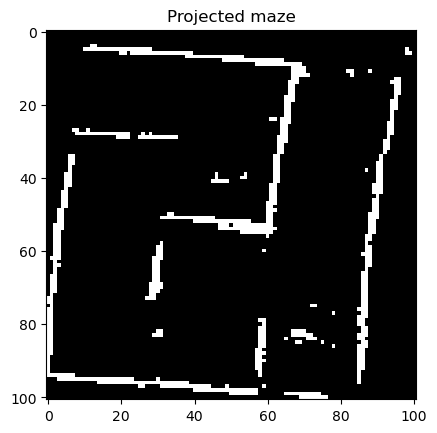

In [182]:
import matplotlib.pyplot as plt

grid = np.flipud(grid) #flip the grid to match the point cloud
plt.imshow(grid, cmap='gray', origin='upper')
# plt.xlabel('X cells')
# plt.ylabel('Y cells')
plt.title('Projected maze')
plt.show()

#TODO need to rotate to the left right after loading the point cloud (in filter_keypoints)


[-86.   9. -86.   7.   9. -84.]


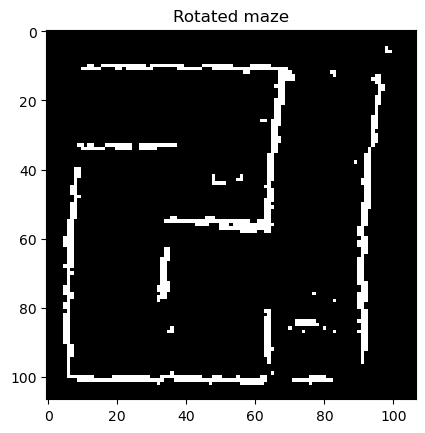

In [183]:
# Perform Hough Transform
hspace, angles, distances = hough_line(grid)
# Find peaks in the Hough transform
_, peak_angles, _ = hough_line_peaks(hspace, angles, distances)
print(np.rad2deg(peak_angles))
# Normalize angles to 0-180 degrees
normalized_angles = np.rad2deg(peak_angles) % 180

# Create histogram of angles
hist, bins = np.histogram(normalized_angles, bins=180, range=(0, 180))

# Find the two largest peaks in the histogram
peaks = np.argsort(hist)[-1]  # Indices of two largest bins
theta_h = bins[peaks]

rotation_angle = (theta_h - 90)
(h, w) = grid.shape[:2]
center = (w // 2, h // 2)

# Compute the bounding box of the rotated image
cos_theta = np.abs(np.cos(np.deg2rad(rotation_angle)))
sin_theta = np.abs(np.sin(np.deg2rad(rotation_angle)))
new_w = int((h * sin_theta) + (w * cos_theta))
new_h = int((h * cos_theta) + (w * sin_theta))

# Adjust the rotation matrix to account for the translation
M = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
M[0, 2] += (new_w - w) / 2
M[1, 2] += (new_h - h) / 2

# Perform the rotation
rotated = cv2.warpAffine(grid, M, (new_w, new_h))

plt.imshow(rotated, cmap='gray', origin='upper')
# plt.xlabel('X cells')
# plt.ylabel('Y cells')
plt.title('Rotated maze')
plt.show()

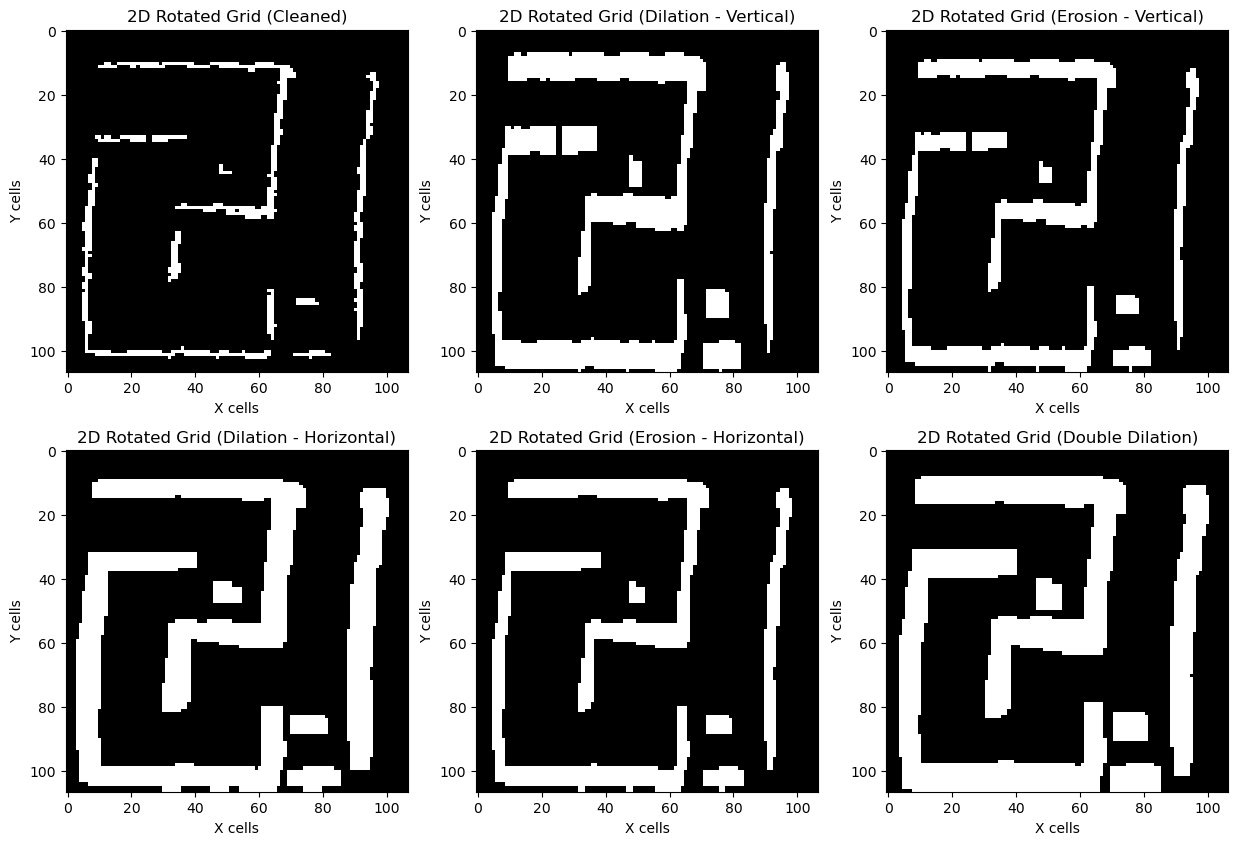

In [184]:
# Remove isolated pixels
connectivity = 8
output = cv2.connectedComponentsWithStats(rotated, connectivity, cv2.CV_32S)

num_stats = output[0] # total number of connected components
labels = output[1] # labeled version of the image where each component is assigned a unique integer label
stats = output[2] # statistics about each component (including its area, bounding box, and other properties).

new_image = rotated.copy()
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.ravel()

for label in range(num_stats):  # foes through each connected component
    if stats[label,cv2.CC_STAT_AREA] == 1 or stats[label,cv2.CC_STAT_AREA] == 2 or stats[label,cv2.CC_STAT_AREA] == 3  :
        new_image[labels == label] = 0
ax[0].imshow(new_image, cmap='gray', origin='upper')
ax[0].set(xlabel='X cells', ylabel='Y cells', title='2D Rotated Grid (Cleaned)')

# Dilation
kernel_dilation_v = np.ones((8,1), np.uint8)
dilated_image_v = cv2.dilate(new_image, kernel_dilation_v, iterations=1)
ax[1].imshow(dilated_image_v, cmap='gray', origin='upper')
ax[1].set(xlabel='X cells', ylabel='Y cells', title='2D Rotated Grid (Dilation - Vertical)')

# Erosion
kernel_erosion = np.ones((4,1), np.uint8)
eroded_image2 = cv2.erode(dilated_image_v, kernel_erosion, iterations=1)
ax[2].imshow(eroded_image2, cmap='gray', origin='upper')
ax[2].set(xlabel='X cells', ylabel='Y cells', title='2D Rotated Grid (Erosion - Vertical)')

# Dilation
kernel_dilation_h = np.ones((1, 6), np.uint8)
dilated_image_h = cv2.dilate(eroded_image2, kernel_dilation_h, iterations=1)
ax[3].imshow(dilated_image_h, cmap='gray', origin='upper')
ax[3].set(xlabel='X cells', ylabel='Y cells', title='2D Rotated Grid (Dilation - Horizontal)')

# Erosion
kernel_erosion = np.ones((1,5), np.uint8)
eroded_image = cv2.erode(dilated_image_h, kernel_erosion, iterations=1)
ax[4].imshow(eroded_image, cmap='gray', origin='upper')
ax[4].set(xlabel='X cells', ylabel='Y cells', title='2D Rotated Grid (Erosion - Horizontal)')

# Double Dilation
kernel_dilation = np.ones((4, 4), np.uint8)
dilated_image = cv2.dilate(eroded_image, kernel_dilation, iterations=1)
ax[5].imshow(dilated_image, cmap='gray', origin='upper')
ax[5].set(xlabel='X cells', ylabel='Y cells', title='2D Rotated Grid (Double Dilation)')
plt.show()

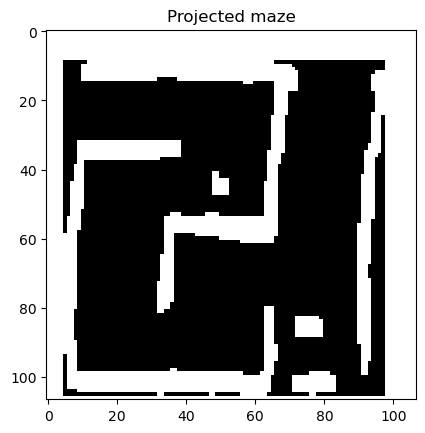

In [185]:
def find_extereme_coords(grid):
    top_y = -1
    bottom_y = -1
    left_x = 200
    right_x = -1
    
    for i, row in enumerate(grid):
        # find first occupied cell in the row
        result = np.where(row == 1)[0]
        # if there is an occupied cell in the row
        if result.size > 0:
            # update bottom most y coord
            bottom_y = i
            # if first occupied cell of grid add it as top most y coord
            if top_y == -1:
                top_y = i
                
            # update current left most x
            cur_left_x = result[0]
            # update left most x
            if cur_left_x < left_x:
                left_x = cur_left_x
            # update current right most x    
            cur_right_x = result[-1]
            # update right most x
            if cur_right_x > right_x:
                right_x = cur_right_x
            
    return top_y, bottom_y, left_x, right_x

def add_edges_to_grid(grid, left, right, up, down):
    new_grid = grid.copy()
    # Add a horizontal border for the top and bottom rows
    new_grid[:up, :] = 1  # Top row border (if valid)
    new_grid[down:, :] = 1  # Bottom row border (if valid)

    # Add a vertical border for the leftmost and rightmost columns
    new_grid[:, :left] = 1  # Left column border (if valid)
    new_grid[:, right:] = 1  # Right column border (if valid)

    return new_grid

top_y, bottom_y, left_x, right_x = find_extereme_coords(eroded_image)

bordered_grid = add_edges_to_grid(eroded_image, left_x, right_x, top_y, bottom_y)

plt.imshow(bordered_grid, cmap='gray', origin='upper')
# plt.xlabel('X cells')
# plt.ylabel('Y cells')
plt.title('Projected maze')
plt.show()

Shortest path: [(20, 10), (20, 11), (21, 11), (21, 12), (22, 12), (22, 13), (23, 13), (23, 14), (23, 15), (23, 16), (23, 17), (23, 18), (23, 19), (23, 20), (23, 21), (23, 22), (23, 23), (23, 24), (23, 25), (23, 26), (23, 27), (23, 28), (23, 29), (23, 30), (23, 31), (23, 32), (23, 33), (23, 34), (23, 35), (23, 36), (23, 37), (23, 38), (23, 39), (24, 39), (25, 39), (26, 39), (27, 39), (28, 39), (29, 39), (30, 39), (31, 39), (32, 39), (33, 39), (34, 39), (35, 39), (36, 39), (37, 39), (38, 39), (39, 39), (40, 39), (41, 39), (42, 39), (43, 39), (44, 39), (45, 39), (45, 38), (45, 37), (45, 36), (45, 35), (45, 34), (45, 33), (45, 32), (45, 31), (45, 30), (45, 29), (45, 28), (45, 27), (45, 26), (45, 25), (46, 25), (46, 24), (47, 24), (47, 23), (48, 23), (48, 22), (49, 22), (50, 22), (51, 22), (52, 22), (53, 22), (53, 21), (54, 21), (55, 21), (56, 21), (57, 21), (58, 21), (59, 21), (60, 21), (61, 21), (62, 21), (62, 20), (63, 20), (64, 20), (65, 20), (66, 20), (67, 20), (68, 20), (69, 20), (70,

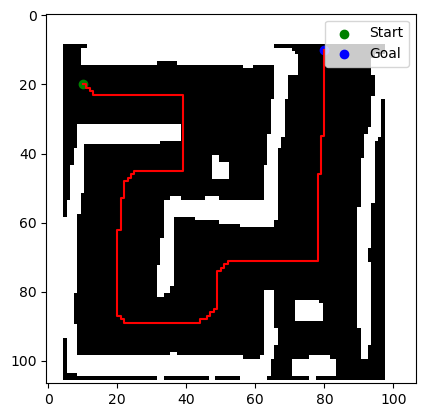

In [186]:
from scipy.ndimage import distance_transform_cdt
# Assuming 'grid' is a 2D NumPy array where 0 represents free space and 1 represents obstacles

def create_penalty_map(grid, max_penalty=10):
    # Invert the grid: obstacles become 0, free space becomes 1
    inverted_grid = 1 - grid
    # Compute the distance transform
    distance_map = distance_transform_cdt(inverted_grid)
    # Normalize the distance map to the range [0, max_penalty]
    penalty_map = max_penalty * (1 - distance_map / np.max(distance_map))
    return penalty_map

def dijkstra_with_penalty(grid, start, goal, penalty_map = None):
    rows, cols = grid.shape
    if penalty_map is None:
        penalty_map = np.zeros_like(grid)
    distances = np.full((rows, cols), np.inf)
    distances[start] = 0
    prev = np.full((rows, cols, 2), -1, dtype=int)
    heap = [(0, start)]

    while heap:
        dist, current = heapq.heappop(heap)
        x, y = current

        if grid[x, y] == 1:
            continue

        if current == goal:
            break

        neighbors = [(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1)]

        for nx, ny in neighbors:
            if 0 <= nx < rows and 0 <= ny < cols and grid[nx, ny] == 0:
                # Comment the penalty map to use default dijkstra
                new_dist = dist + 1 + penalty_map[nx, ny]
                if new_dist < distances[nx, ny]:
                    distances[nx, ny] = new_dist
                    prev[nx, ny] = [x, y]
                    heapq.heappush(heap, (new_dist, (nx, ny)))

    path = []
    current = goal
    if distances[goal] == np.inf:
        print("No path found between", start, "and", goal)
        return path

    while current != (-1, -1):
        path.append(current)
        x, y = current
        current = tuple(prev[x, y])
        if current == (-1, -1):
            break

    path.reverse()
    return path


def manhattan_distance(a, b):
    """Calculate the Manhattan distance between two points a and b."""
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def a_star(grid, start, goal):
    rows, cols = grid.shape
    # Initialize distances from start to each cell as infinity
    distances = np.full((rows, cols), np.inf)
    distances[start] = 0
    # Initialize the previous node tracker
    prev = np.full((rows, cols, 2), -1, dtype=int)

    # Priority queue with tuples: (estimated_total_cost, cost_so_far, (x, y))
    heap = [(manhattan_distance(start, goal), 0, start)]

    while heap:
        estimated_total_cost, cost_so_far, current = heapq.heappop(heap)
        x, y = current

        if grid[x, y] == 1:
            continue  # Skip obstacles

        if current == goal:
            break  # Goal reached

        # Four adjacent movements: up, down, left, right
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy

            # Check boundaries and obstacles
            if 0 <= nx < rows and 0 <= ny < cols and grid[nx, ny] == 0:
                new_cost = cost_so_far + 1  # Assume uniform cost
                if new_cost < distances[nx, ny]:
                    distances[nx, ny] = new_cost
                    prev[nx, ny] = [x, y]
                    # Update the estimated total cost with heuristic
                    estimated = new_cost + manhattan_distance((nx, ny), goal)
                    heapq.heappush(heap, (estimated, new_cost, (nx, ny)))

    # Reconstruct the path from goal to start
    path = []
    current = goal
    if distances[goal] == np.inf:
        print("No path found between", start, "and", goal)
        return path  # Empty path

    while current != (-1, -1):
        path.append(current)
        x, y = current
        current = tuple(prev[x, y])
        if current == (-1, -1):
            break

    path.reverse()  # Reverse to get path from start to goal
    return path


def a_star_with_penalty(grid, start, goal, penalty_map = None):
    rows, cols = grid.shape
    if penalty_map is None:
        penalty_map = np.zeros_like(grid)
    distances = np.full((rows, cols), np.inf)
    distances[start] = 0
    prev = np.full((rows, cols, 2), -1, dtype=int)
    heap = [(manhattan_distance(start, goal), 0, start)]

    while heap:
        estimated_total_cost, cost_so_far, current = heapq.heappop(heap)
        x, y = current

        if grid[x, y] == 1:
            continue

        if current == goal:
            break

        neighbors = [(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1)]

        for nx, ny in neighbors:
            if 0 <= nx < rows and 0 <= ny < cols and grid[nx, ny] == 0:
            
                new_cost = cost_so_far + 1 + penalty_map[nx, ny]
                if new_cost < distances[nx, ny]:
                    distances[nx, ny] = new_cost
                    prev[nx, ny] = [x, y]
                    estimated = new_cost + manhattan_distance((nx, ny), goal)
                    heapq.heappush(heap, (estimated, new_cost, (nx, ny)))

    path = []
    current = goal
    if distances[goal] == np.inf:
        print("No path found between", start, "and", goal)
        return path

    while current != (-1, -1):
        path.append(current)
        x, y = current
        current = tuple(prev[x, y])
        if current == (-1, -1):
            break

    path.reverse()
    return path


# Define your grid (0 = free space, 1 = obstacle)
grid = bordered_grid.copy()
penalty_map = create_penalty_map(grid)

# Define start and goal positions
# (coordinates are y, x)
# maze 1
start = (20, 10)
goal = (10, 80)

# maze 2
# start = (25, 52)
# goal = (105, 110)

# path = dijkstra_with_penalty(grid,start,goal, penalty_map)
path = a_star_with_penalty(grid, start, goal, penalty_map)
print("Shortest path:", path)

# Visualize the grid and the path
plt.imshow(1-bordered_grid, cmap='Greys', origin='upper')

# Plot the path
if path:
    path_x, path_y = zip(*path)
    plt.plot(path_y, path_x, color='red')  # Note: x and y are swapped due to image coordinates

plt.scatter(start[1], start[0], marker='o', color='green', label='Start')
plt.scatter(goal[1], goal[0], marker='o', color='blue', label='Goal')
plt.legend()
plt.show()

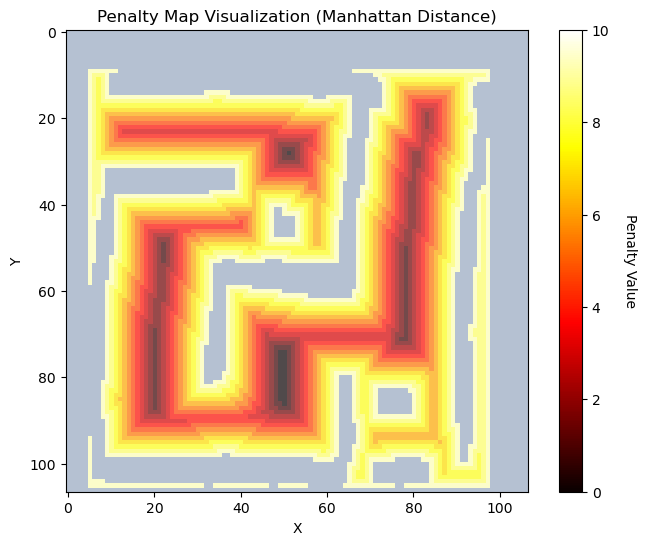

In [188]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot penalty map
cax = ax.imshow(penalty_map, cmap='hot', interpolation='nearest')

# Overlay grid to show obstacles
ax.imshow(grid, cmap='Blues', alpha=0.3, interpolation='nearest')

# Add a colorbar with a label
cbar = fig.colorbar(cax)
cbar.set_label('Penalty Value', rotation=270, labelpad=20)

# Set labels and title
ax.set_title('Penalty Map Visualization (Manhattan Distance)')
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

In [147]:
Define the directions
DIRECTIONS = ['N', 'E', 'S', 'W']
DIRECTION_VECTORS = {
    'N': (-1, 0),
    'E': (0, 1),
    'S': (1, 0),
    'W': (0, -1)
}

def get_direction_vector(start, end):
    return (end[0] - start[0], end[1] - start[1])

def get_direction_name(vector):
    for name, vec in DIRECTION_VECTORS.items():
        if vec == vector:
            return name
    return None

def turn_direction(current, target):
    current_idx = DIRECTIONS.index(current)
    target_idx = DIRECTIONS.index(target)
    if current_idx == target_idx:
        return "forward"
    elif (current_idx + 1) % 4 == target_idx:
        return "right"
    elif (current_idx - 1) % 4 == target_idx:
        return "left"
    else:
        return "backward"

def generate_instructions(path, start_direction='E'):
    if len(path) < 2:
        return []

    instructions = []
    current_direction = start_direction  # Assume starting direction is East

    for i in range(1, len(path)):
        start = path[i - 1]
        end = path[i]
        direction_vector = get_direction_vector(start, end)
        next_direction = get_direction_name(direction_vector)

        if next_direction is None:
            continue

        turn = turn_direction(current_direction, next_direction)
        if turn != "forward":
            instructions.append(f"Turn {turn}")
        instructions.append("Move forward")
        current_direction = next_direction

    return instructions

# Generate instructions for the given path
instructions = generate_instructions(path)
for instruction in instructions:
    print(instruction)

Move forward
Turn right
Move forward
Turn left
Move forward
Turn right
Move forward
Turn left
Move forward
Turn right
Move forward
Turn left
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Turn right
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Turn right
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Move forward
Turn left
Move forward
Turn right
Move forward
Move forward
Move forward
Move forward
Turn left
Move forward
Turn right
Mo